<a href="https://colab.research.google.com/github/anissa762/goldfish/blob/main/goldfish3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install --upgrade optuna ta catboost
!pip install optuna-integration

import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import optuna
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from catboost import CatBoostRegressor, Pool


Mounted at /content/drive
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=8b41ee586d4d1fb92c11b6ddf01b5b365b614ace9a5592009ae99cf4ae83715f
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 6.8 MB/s eta 0:00:00


In [2]:
#---------------------------------------------
# User-Defined Parameters
#---------------------------------------------
DATA_PATH = '/content/drive/MyDrive/data/'
ELECTION_DATA_PATH = '/content/drive/MyDrive/final_stock_rankings2.csv'

# Prediction horizon (days)
TARGET_WINDOW_DAYS = 30

# Investment amount
TOTAL_INVESTMENT = 30.0

# Number of top stocks
TOP_N = 5

# Prioritize Dec/Jan weighting: samples in December and January will have higher training weight
DEC_JAN_WEIGHT = 2.0  # adjust this factor as needed

In [3]:
#---------------------------------------------
# Load Election Data
#---------------------------------------------
if os.path.exists(ELECTION_DATA_PATH):
    election_data = pd.read_csv(ELECTION_DATA_PATH)
else:
    raise FileNotFoundError("Election impact data not found. Please ensure final_stock_rankings2.csv is in data folder.")


election_data['ElectionImpact'] = election_data['FinalScore']

# Keep track of tickers with election data
valid_tickers = set(election_data['Ticker'].unique())


In [4]:

#---------------------------------------------
# Load Stock Data
#---------------------------------------------
csv_files = glob.glob(os.path.join(DATA_PATH, '*_data_cleaned.csv'))
stock_data = {}

def add_technical_indicators(df):
    df = df.copy()
    # Moving Averages
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
    # MACD
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_diff'] = macd.macd_diff()
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()
    # Volume MA
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    # OBV
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    # EMAs
    df['EMA10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
    df['EMA50'] = ta.trend.EMAIndicator(df['Close'], window=50).ema_indicator()
    df.dropna(inplace=True)
    return df

for file in csv_files:
    ticker = os.path.basename(file).split('_')[0]
    # Only consider tickers that appear in election_data
    if ticker not in valid_tickers:
        continue
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df = add_technical_indicators(df)
    # Merge ElectionImpact
    score_val = election_data.loc[election_data['Ticker'] == ticker, 'ElectionImpact']
    if not score_val.empty:
        election_impact = score_val.values[0]
    else:
        # If ticker not found, skip
        continue
    df['ElectionImpact'] = election_impact

    # Additional Date Features
    df['Month'] = df['Date'].dt.month
    df['DayOfYear'] = df['Date'].dt.dayofyear

    # Future Return as target
    df['Future_Close'] = df['Close'].shift(-TARGET_WINDOW_DAYS)
    df['Target_Return'] = ((df['Future_Close'] - df['Close']) / df['Close']) * 100
    df.dropna(inplace=True)

    # Store
    stock_data[ticker] = df

In [5]:
# If you want to simulate training up to Dec 16, 2024, and predict after,
# you can filter data here if your data extends beyond that date:
# TRAIN_END_DATE = datetime(2024, 12, 16)
# for ticker in stock_data:
#     stock_data[ticker] = stock_data[ticker][stock_data[ticker]['Date'] <= TRAIN_END_DATE]

#---------------------------------------------
# Combine Data from All Stocks
#---------------------------------------------
feature_cols = ['Open', 'Close', 'High', 'Low', 'Volume',
                'MA10', 'MA50', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff',
                'Bollinger_High', 'Bollinger_Low', 'Volume_MA20', 'OBV',
                'EMA10', 'EMA50', 'ElectionImpact', 'Month', 'DayOfYear']

X_list = []
y_list = []
weights_list = []

for ticker, df in stock_data.items():
    if len(df) < (TARGET_WINDOW_DAYS + 1):
        continue
    X_list.append(df[feature_cols].values)
    y_list.append(df['Target_Return'].values)
    # Weight samples: December (12) and January (1) get higher weights
    # Otherwise weight = 1
    sample_weights = np.ones(len(df))
    dec_jan_mask = (df['Month'] == 12) | (df['Month'] == 1)
    sample_weights[dec_jan_mask] = DEC_JAN_WEIGHT
    weights_list.append(sample_weights)

X = np.vstack(X_list)
y = np.hstack(y_list)
sample_weights = np.hstack(weights_list)

In [6]:
#---------------------------------------------
# Train-Test Split using TimeSeriesSplit
#---------------------------------------------
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    w_train, w_test = sample_weights[train_index], sample_weights[test_index]

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
#---------------------------------------------
# Hyperparameter Tuning with Optuna (CatBoost)
#---------------------------------------------
import optuna
from catboost import cv as catboost_cv

# Specify a storage location for the Optuna study
STUDY_DB_PATH = os.path.join(DATA_PATH, 'catboost_study.db')
STUDY_NAME = 'catboost_hyperparam_tuning'

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'od_wait': 50,
        'random_seed': 42,
        'loss_function': 'RMSE',
        'verbose': False
    }

    cat_data = Pool(X_train_scaled, y_train, weight=w_train)

    # Perform cross-validation
    cv_out = catboost_cv(cat_data, params, fold_count=3, plot=False, verbose=False, early_stopping_rounds=50)
    best_rmse = cv_out['test-RMSE-mean'].min()
    return best_rmse

# Create or load the existing study from the SQLite database
study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=f"sqlite:///{STUDY_DB_PATH}",
    load_if_exists=True,
    direction='minimize'
)

# Run optimization - if runtime disconnects, you can simply rerun this cell and it will resume from the database
study.optimize(objective_catboost, n_trials=50, timeout=600)  # Adjust as needed

best_params = study.best_params
best_params.update({
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': False
})

# Save the best_params and the study itself for future reference
with open(os.path.join(DATA_PATH, 'best_params_catboost.pkl'), 'wb') as f:
    pickle.dump(best_params, f)
study.trials_dataframe().to_csv(os.path.join(DATA_PATH, 'optuna_catboost_trials.csv'), index=False)

[I 2024-12-10 09:02:29,506] Using an existing study with name 'catboost_hyperparam_tuning' instead of creating a new one.


Training on fold [0/3]

bestTest = 5.157733075
bestIteration = 1695

Training on fold [1/3]

bestTest = 5.249241511
bestIteration = 1695

Training on fold [2/3]


[I 2024-12-10 09:19:10,674] Trial 47 finished with value: 5.2062181128907055 and parameters: {'iterations': 1696, 'depth': 10, 'learning_rate': 0.20689327245275055, 'l2_leaf_reg': 6.31085439851343, 'random_strength': 6.995533653866016, 'bagging_temperature': 3.0280177655071863}. Best is trial 35 with value: 5.01274986292982.



bestTest = 5.211679753
bestIteration = 1695



In [9]:
#---------------------------------------------
# Train Final Model
#---------------------------------------------
# Enable snapshots in CatBoost so if training stops you can resume
best_params.update({
    'save_snapshot': True,
    'snapshot_file': os.path.join(DATA_PATH, 'catboost_training_snapshot.cbm')
})

final_model = CatBoostRegressor(**best_params)

# If the training was interrupted previously and a snapshot file exists,
# CatBoost will resume from that snapshot.
final_model.fit(X_train_scaled, y_train, sample_weight=w_train)

# Evaluate
y_pred = final_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Save model and scaler
final_model.save_model(os.path.join(DATA_PATH, 'final_catboost_model.cbm'))
with open(os.path.join(DATA_PATH, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

# Also save predictions if needed
pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).to_csv(os.path.join(DATA_PATH, 'catboost_predictions.csv'), index=False)

R² Score: -0.3772
RMSE: 11.7577
MAE: 8.6435



### Investment Allocation ###

    Stock  Investment  Predicted_Return  Expected_Profit
0     WDC        0.12         68.243519         0.081892
1    TSLA        0.12         42.297292         0.050757
2    AXON        0.12         41.286161         0.049543
3     MCK        0.12         20.628754         0.024755
4     HUM        0.12         20.174985         0.024210
..    ...         ...               ...              ...
202   NEM        0.12         -8.486696        -0.010184
203   AMD        0.12         -9.731613        -0.011678
204  FBIN        0.12        -10.224991        -0.012270
205   LLY        0.12        -12.690290        -0.015228
206  MSTR        0.12        -22.589663        -0.027108

[207 rows x 4 columns]

Total Investment: £30.0
Total Expected Profit: £1.23


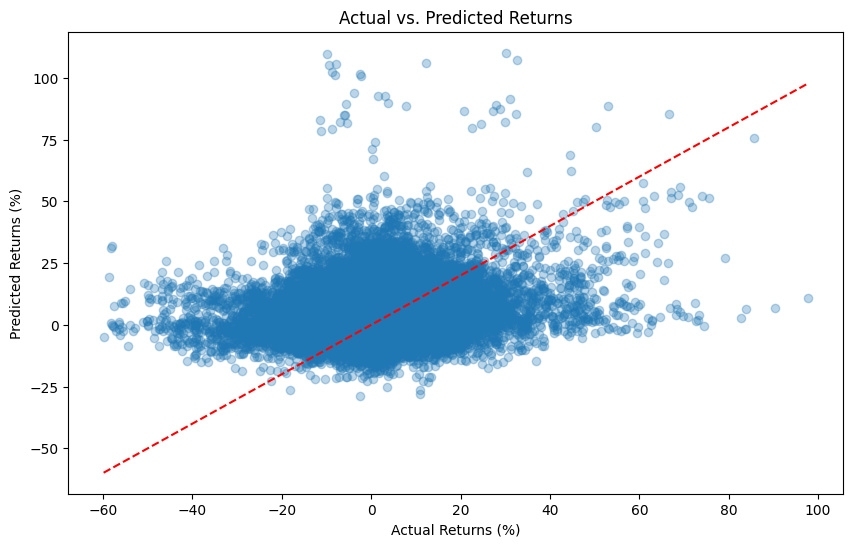

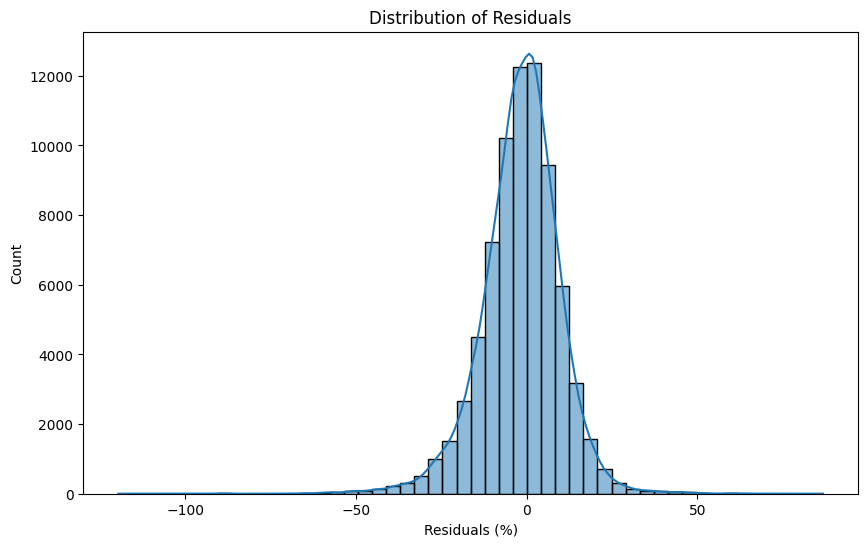

In [15]:
#---------------------------------------------
# Make Predictions for Investment Allocation
#---------------------------------------------
# We'll take the latest available data point from each stock and predict future return.
allocation_candidates = []
for ticker, df in stock_data.items():
    if len(df) < (TARGET_WINDOW_DAYS + 1):
        continue
    latest_row = df.iloc[-1]
    feat = latest_row[feature_cols].values.reshape(1, -1)
    feat_scaled = scaler.transform(feat)
    pred_return = final_model.predict(feat_scaled)[0]
    allocation_candidates.append({
        'Stock': ticker,
        'Predicted_Return': pred_return
    })

alloc_df = pd.DataFrame(allocation_candidates)
alloc_df.sort_values(by='Predicted_Return', ascending=False, inplace=True)
alloc_df.reset_index(drop=True, inplace=True)

TOP_N = 250
# Select top N stocks and allocate equally or proportionally
top_stocks = alloc_df.head(TOP_N).copy()
# Equal allocation
top_stocks['Investment'] = TOTAL_INVESTMENT / TOP_N
top_stocks['Expected_Profit'] = top_stocks['Investment'] * (top_stocks['Predicted_Return'] / 100)

print("\n### Investment Allocation ###\n")
print(top_stocks[['Stock', 'Investment', 'Predicted_Return', 'Expected_Profit']])
print(f"\nTotal Investment: £{TOTAL_INVESTMENT}")
print(f"Total Expected Profit: £{top_stocks['Expected_Profit'].sum():.2f}")

# Plot Actual vs. Predicted on test set
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Returns (%)')
plt.ylabel('Predicted Returns (%)')
plt.title('Actual vs. Predicted Returns')
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'r--')
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals (%)')
plt.show()

In [13]:


#---------------------------------------------
# Additional Metrics
#---------------------------------------------
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    y_true = y_true[non_zero]
    y_pred = y_pred[non_zero]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")

print("Done.")

MAPE: 419.60%
Done.
